# **Imports 📢**

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader, random_split

import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from torchmetrics import Accuracy
from tqdm import tqdm

# **Dataset 🗂️**

## Read Dataset

In [ ]:
## read dataset
!uncompress ./data/shuttle.trn.Z

In [7]:
import csv

def read_file(file, phase):
    with open(file, 'rb') as fh:
      decompressed_data = fh.read()
    list_data = decompressed_data.decode('utf-8').splitlines()
    with open(phase + ".csv", "w", newline="") as f:
        writer = csv.writer(f)
        for line in list_data:
            # making cells by using , delimiters
            writer.writerow(line.split(" "))

In [14]:
## readfile
read_file('./data/shuttle.trn', './data/train')

In [3]:
data = pd.read_csv('./data/train.csv', header=None)
data.head()

,0,1,2,3,4,5,6,7,8,9
0,50,21,77,0,28,0,27,48,22,2
1,55,0,92,0,0,26,36,92,56,4
2,53,0,82,0,52,-5,29,30,2,1
3,37,0,76,0,28,18,40,48,8,1
4,37,0,79,0,34,-26,43,46,2,1


In [4]:
len(data)

43500

In [5]:
X = data.iloc[:, :-1]
y = data.iloc[:, -1]

In [6]:
y.replace([1, 2, 3, 4, 5, 6, 7], [0, 1, 2, 3, 4, 5, 6], inplace=True)

## Split

In [7]:
x_train, x_valid, y_train, y_valid = train_test_split(X, y, test_size=0.3, random_state=42)

## Preprocess

In [8]:
x_train = torch.FloatTensor(x_train.values)
y_train = torch.LongTensor(y_train.values)

x_valid = torch.FloatTensor(x_valid.values)
y_valid = torch.LongTensor(y_valid.values)

mu = x_train.mean(dim=0)
std = x_train.std(dim=0)

x_train = x_train - mu / std
x_valid = x_valid - mu / std

## Dataloader

In [9]:
train_dataset = TensorDataset(x_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

valid_dataset = TensorDataset(x_valid, y_valid)
valid_loader = DataLoader(valid_dataset, batch_size=200)

# **Model 🧠**

In [10]:
y.unique()

array([1, 3, 0, 4, 2, 6, 5])

In [11]:
num_feats = 9
num_class = 7
h1 = 64
h2 = 32

model = nn.Sequential(nn.Linear(num_feats, h1),
                      nn.ReLU(),
                      # nn.Dropout(0.5),
                      nn.Linear(h1, h2),
                      nn.ReLU(),
                      nn.Linear(h2, num_class))

model

Sequential(
  (0): Linear(in_features=9, out_features=64, bias=True)
  (1): ReLU()
  (2): Linear(in_features=64, out_features=32, bias=True)
  (3): ReLU()
  (4): Linear(in_features=32, out_features=7, bias=True)
)

# **Device ⚙️**

In [12]:
# device = 'cuda' if torch.cuda.is_available() else 'cpu'
device = 'cpu'
model = model.to(device)

# **Loss ⚖️**

## CrossEntropyLoss

In [13]:
loss_fn = nn.CrossEntropyLoss()

# **Optimizer📻**

## SGD

In [14]:
optimizer = optim.SGD(model.parameters(),
                      lr=0.01,
                      momentum=0.9,
                      nesterov=True,
                      weight_decay=1e-4)

# **Utils 🧰**

In [15]:
class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

# **Functions** 🧮

In [16]:
def train_one_epoch(model, train_loader, loss_fn, optimizer, epoch=None):
  model.train()
  loss_train = AverageMeter()
  acc_train = Accuracy(task='multiclass', num_classes=num_class).to(device)
  with tqdm(train_loader, unit='batch') as tepoch:
    for inputs, targets in tepoch:
      if epoch is not None:
        tepoch.set_description(f'Epoch {epoch}')
      inputs = inputs.to(device)
      targets = targets.to(device)

      outputs = model(inputs)
      loss = loss_fn(outputs, targets)

      loss.backward()
      optimizer.step()
      optimizer.zero_grad()

      loss_train.update(loss.item())
      acc_train(outputs, targets.int())

      tepoch.set_postfix(loss=loss_train.avg,
                         accuracy=100.*acc_train.compute().item())
  return model, loss_train.avg, acc_train.compute().item()

In [17]:
def evaluate(model, valid_loader, loss_fn):
  model.eval()
  with torch.no_grad():
    loss_valid = AverageMeter()
    acc_valid = Accuracy(task='multiclass', num_classes=num_class).to(device)
    for i, (inputs, targets) in enumerate(valid_loader):
      inputs = inputs.to(device)
      targets = targets.to(device)

      outputs = model(inputs)
      loss = loss_fn(outputs, targets)

      loss_valid.update(loss.item())
      acc_valid(outputs, targets.int())

  return loss_valid.avg, acc_valid.compute()

# **Efficient way for set hyperparams 🔨**

In [75]:
model = nn.Sequential(nn.Linear(num_feats, h1),
                      nn.ReLU(),
                      nn.Linear(h1, h2),
                      nn.ReLU(),
                      nn.Linear(h2, num_class))

optimizer = optim.SGD(model.parameters(), lr=0.01, weight_decay=1e-4)

## Step 1: check forward path

Calculate loss for one batch

In [76]:
x_batch, y_batch = next(iter(train_loader))
yp = model(x_batch)
loss_fn(yp, y_batch)

tensor(1.7809, grad_fn=<NllLossBackward0>)

## Step 2: check backward path

Select 5 random batches and overfit the model

In [77]:
mini_train_dataset, _ = random_split(train_dataset, lengths=(100, len(train_dataset) - 100))
mini_loader = DataLoader(mini_train_dataset, 20, shuffle=True)

In [78]:
for epoch in range(500):
    model, _, _ = train_one_epoch(model,
                                  mini_loader,
                                  loss_fn,
                                  optimizer,
                                  epoch)

Epoch 499: 100%|██████████| 5/5 [00:00<00:00, 167.13batch/s, accuracy=100, loss=0.00102]


## Step 3: select best lr

Train all data for one epoch

In [81]:
for lr in [0.1, 0.01, 0.001, 0.0001]:
  model = nn.Sequential(nn.Linear(num_feats, h1),
                        nn.ReLU(),
                        nn.Linear(h1, h2),
                        nn.ReLU(),
                        nn.Linear(h2, num_class))

  optimizer = optim.SGD(model.parameters(), lr=lr, weight_decay=1e-4)

  print(f'LR={lr}')
  for epoch in range(5):
    model, _, _ = train_one_epoch(model,
                                  train_loader,
                                  loss_fn,
                                  optimizer,
                                  epoch)
  print()

LR=0.1


Epoch 4: 100%|██████████| 952/952 [00:06<00:00, 147.41batch/s, accuracy=78.3, loss=0.674]



LR=0.01


Epoch 4: 100%|██████████| 952/952 [00:06<00:00, 153.08batch/s, accuracy=98.9, loss=0.0399]



LR=0.001


Epoch 4: 100%|██████████| 952/952 [00:06<00:00, 154.21batch/s, accuracy=97.6, loss=0.124]



LR=0.0001


Epoch 4: 100%|██████████| 952/952 [00:06<00:00, 155.21batch/s, accuracy=94.2, loss=0.224]

## Step 4: small grid (optional)

Create a small grid based on the WD and the best LR



In [84]:
for lr in [0.1, 0.15, 0.2, 0.25, 0.3]:
  for wd in [0., 1e-4, 1e-5, 1e-6]:
    model = nn.Sequential(nn.Linear(num_feats, h1),
                      nn.ReLU(),
                      nn.Linear(h1, h2),
                      nn.ReLU(),
                      nn.Linear(h2, num_class))

    optimizer = optim.SGD(model.parameters(), lr=lr, weight_decay=wd)

    print(f'LR={lr}, WD={wd}')
    for epoch in range(5):
      model, _, _ = train_one_epoch(model,
                                    train_loader,
                                    loss_fn,
                                    optimizer,
                                    epoch)
    print()
    # torch.save(...)

LR=0.1, WD=0.0


Epoch 4: 100%|██████████| 952/952 [00:06<00:00, 153.47batch/s, accuracy=78.3, loss=0.674]



LR=0.1, WD=0.0001


Epoch 4: 100%|██████████| 952/952 [00:05<00:00, 160.83batch/s, accuracy=78.3, loss=nan]



LR=0.1, WD=1e-05


Epoch 4: 100%|██████████| 952/952 [00:06<00:00, 154.00batch/s, accuracy=78.3, loss=0.673]



LR=0.1, WD=1e-06


Epoch 4: 100%|██████████| 952/952 [00:07<00:00, 133.63batch/s, accuracy=78.3, loss=nan]



LR=0.15, WD=0.0


Epoch 4: 100%|██████████| 952/952 [00:06<00:00, 151.68batch/s, accuracy=78.3, loss=0.673]



LR=0.15, WD=0.0001


Epoch 4:  26%|██▌       | 248/952 [00:01<00:04, 142.60batch/s, accuracy=78, loss=nan]  


KeyboardInterrupt: 

## Step 5: train more epochs

In [85]:
!mkdir model

In [18]:
num_epochs = 20
best_valid_loss = torch.inf

loss_train_hist = []
loss_valid_hist = []

acc_train_hist = []
acc_valid_hist = []

for epoch in range(num_epochs):
  model, loss_train, acc_train = train_one_epoch(model,
                                                 train_loader,
                                                 loss_fn,
                                                 optimizer,
                                                 epoch)
  loss_valid, acc_valid = evaluate(model,
                                   valid_loader,
                                   loss_fn)

  loss_train_hist.append(loss_train)
  loss_valid_hist.append(loss_valid)

  acc_train_hist.append(acc_train)
  acc_valid_hist.append(acc_valid)

  if loss_valid < best_valid_loss:
    torch.save(model, './model/model.pt')
    best_valid_loss = loss_valid
    print('Model Saved!')

  print(f'Valid: Loss = {loss_valid:.4}, Acc = {acc_valid:.4}\n')

Epoch 0: 100%|██████████| 952/952 [00:06<00:00, 138.01batch/s, accuracy=78.4, loss=1.57]


Model Saved!
Valid: Loss = 0.6797, Acc = 0.7857



Epoch 1: 100%|██████████| 952/952 [00:06<00:00, 141.96batch/s, accuracy=78.3, loss=0.68] 


Model Saved!
Valid: Loss = 0.6714, Acc = 0.7857



Epoch 2: 100%|██████████| 952/952 [00:05<00:00, 164.69batch/s, accuracy=78.3, loss=0.676]


Model Saved!
Valid: Loss = 0.6691, Acc = 0.7857



Epoch 3: 100%|██████████| 952/952 [00:05<00:00, 165.29batch/s, accuracy=78.3, loss=0.675]


Model Saved!
Valid: Loss = 0.6684, Acc = 0.7857



Epoch 4: 100%|██████████| 952/952 [00:05<00:00, 171.01batch/s, accuracy=78.3, loss=0.674]


Model Saved!
Valid: Loss = 0.6677, Acc = 0.7857



Epoch 5: 100%|██████████| 952/952 [00:05<00:00, 170.89batch/s, accuracy=78.3, loss=0.674]


Model Saved!
Valid: Loss = 0.6672, Acc = 0.7857



Epoch 6: 100%|██████████| 952/952 [00:05<00:00, 171.56batch/s, accuracy=78.3, loss=0.673]


Valid: Loss = 0.6674, Acc = 0.7857



Epoch 7: 100%|██████████| 952/952 [00:05<00:00, 159.48batch/s, accuracy=78.3, loss=0.673]


Valid: Loss = 0.6675, Acc = 0.7857



Epoch 8: 100%|██████████| 952/952 [00:05<00:00, 170.03batch/s, accuracy=78.3, loss=0.673]


Model Saved!
Valid: Loss = 0.6669, Acc = 0.7857



Epoch 9: 100%|██████████| 952/952 [00:05<00:00, 166.55batch/s, accuracy=78.3, loss=0.672]


Model Saved!
Valid: Loss = 0.6668, Acc = 0.7857



Epoch 10: 100%|██████████| 952/952 [00:05<00:00, 167.93batch/s, accuracy=78.3, loss=0.672]


Valid: Loss = 0.6672, Acc = 0.7857



Epoch 11: 100%|██████████| 952/952 [00:05<00:00, 173.56batch/s, accuracy=78.3, loss=0.672]


Model Saved!
Valid: Loss = 0.6666, Acc = 0.7857



Epoch 12: 100%|██████████| 952/952 [00:05<00:00, 172.18batch/s, accuracy=78.3, loss=0.672]


Model Saved!
Valid: Loss = 0.6665, Acc = 0.7857



Epoch 13: 100%|██████████| 952/952 [00:05<00:00, 172.97batch/s, accuracy=78.3, loss=0.672]


Model Saved!
Valid: Loss = 0.6665, Acc = 0.7857



Epoch 14: 100%|██████████| 952/952 [00:05<00:00, 175.00batch/s, accuracy=78.3, loss=0.672]


Model Saved!
Valid: Loss = 0.6664, Acc = 0.7857



Epoch 15: 100%|██████████| 952/952 [00:05<00:00, 171.52batch/s, accuracy=78.3, loss=0.672]


Valid: Loss = 0.6668, Acc = 0.7857



Epoch 16: 100%|██████████| 952/952 [00:05<00:00, 174.30batch/s, accuracy=78.3, loss=0.672]


Model Saved!
Valid: Loss = 0.6664, Acc = 0.7857



Epoch 17: 100%|██████████| 952/952 [00:05<00:00, 175.03batch/s, accuracy=78.3, loss=0.672]


Valid: Loss = 0.668, Acc = 0.7857



Epoch 18: 100%|██████████| 952/952 [00:05<00:00, 176.34batch/s, accuracy=78.3, loss=0.672]


Valid: Loss = 0.6665, Acc = 0.7857



Epoch 19: 100%|██████████| 952/952 [00:05<00:00, 173.37batch/s, accuracy=78.3, loss=0.672]


Model Saved!
Valid: Loss = 0.6662, Acc = 0.7857



# **Plot📉**

### Loss

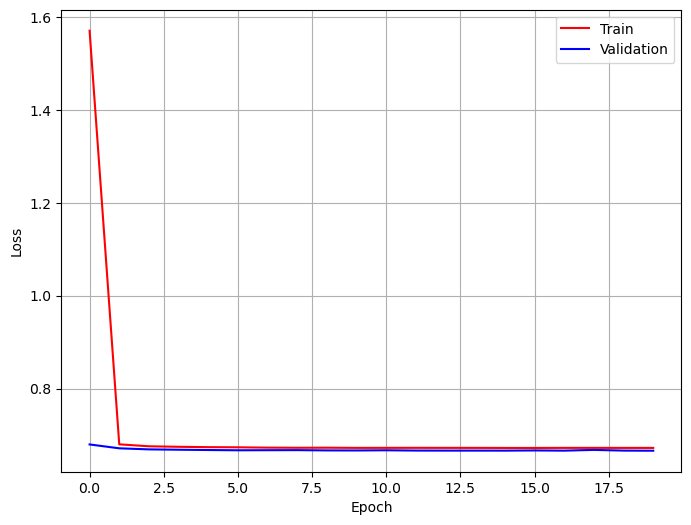

In [19]:
plt.figure(figsize=(8, 6))

plt.plot(range(num_epochs), loss_train_hist, 'r-', label='Train')
plt.plot(range(num_epochs), loss_valid_hist, 'b-', label='Validation')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.legend()

### Accuracy

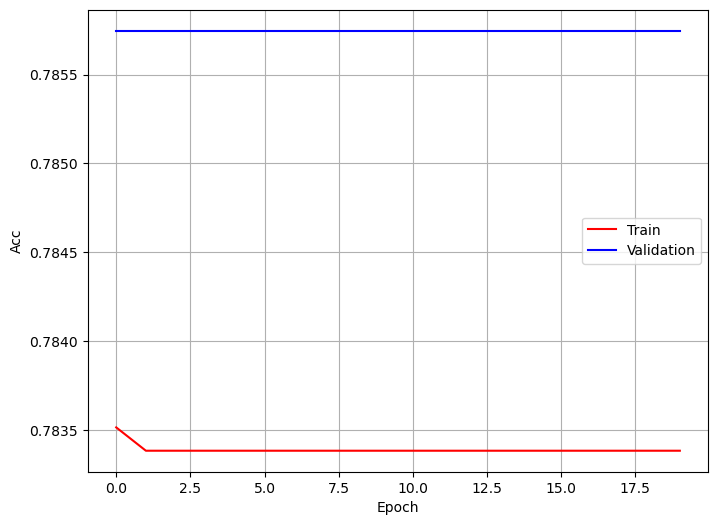

In [20]:
plt.figure(figsize=(8, 6))

plt.plot(range(num_epochs), acc_train_hist, 'r-', label='Train')
plt.plot(range(num_epochs), acc_valid_hist, 'b-', label='Validation')

plt.xlabel('Epoch')
plt.ylabel('Acc')
plt.grid(True)
plt.legend()

# **Save & Prediction🔎**